## Uncalibrated model performance

In [ ]:
import pandas as pd
import re
from ZeroRateCurve import ExampleLinearlyInterpolatedZeroRateCurve
from HullWhite import OneFactorHullWhiteModel
from Swaption import EuropeanSwaption, SwaptionType
from HullWhiteTrinomialTree import OneFactorHullWhiteTrinomialTree
from HullWhiteTreeSwaptionPricer import HullWhiteTreeEuropeanSwaptionPricer
import matplotlib.pyplot as plt

# read and filter market quotes data.
df = pd.read_csv("./data/swaption_market_quotes.csv")
df = df.dropna()
df = df[df['Description'].str.contains("EUR Swaption Premium", na=False)]

# function for extracting tenors
def extract_tenors(description):
    matches = re.findall(r'(\d+)([YM])', description.upper())
    tenors = []
    for amount, unit in matches:
        amount = float(amount)
        if unit == 'M':
            amount /= 12 
        tenors.append(amount)
    
    if len(tenors) >= 2:
        return tenors[0], tenors[1]
    elif len(tenors) == 1:
        return tenors[0], None
    else:
        return None, None
    
def price_swaption(hw_model, swap_start, swap_end, timestep):
    zcb_curve = ExampleLinearlyInterpolatedZeroRateCurve()
    swaption = EuropeanSwaption(
        swaption_type=SwaptionType.PAYER,
        expiry=swap_start,
        swap_start=swap_start,
        swap_end=swap_end,
        payment_frequency=0.5,
        notional=1,
        strike=0.00,
        fixed=0.00,
    )

    # compute and set the par swap rates
    swaption.set_ATM_strike_fixed_rate_and_strike(zcb_curve)

    # initialize the tree
    tree = OneFactorHullWhiteTrinomialTree(hw_model, 
                                        swaption.get_valuation_times(), zcb_curve, timestep)
    tree.build_tree(verbose=False)

    # price it!
    pricer = HullWhiteTreeEuropeanSwaptionPricer(tree)
    return pricer.price(swaption) * 10000 # convert to bps

baseline_model = OneFactorHullWhiteModel(a=0.003)
zcb_curve = ExampleLinearlyInterpolatedZeroRateCurve()
errors = []
for index, row in df.iterrows():
    print(f"Current index: {index}, Description: {row["Description"]}")
    swap_start, swap_dur = extract_tenors(row["Description"])
    swap_end = swap_start + swap_dur
    swap_actual_price = row["Quoted_Premium"]
    
    swap_start = round(swap_start, 4)
    swap_end = round(swap_end, 4)
    computed_price = price_swaption(baseline_model, swap_start, swap_end, 0.25)
    
    error = computed_price - swap_actual_price
    errors.append(error)
    print(f"\tComputed Price: {computed_price}; Actual Price: {swap_actual_price}; Error: {error}")


Current index: 0, Description: EUR Swaption Premium 3M10Y
	Computed Price: 132.4030017486833; Actual Price: 193.278; Error: -60.8749982513167
Current index: 2, Description: EUR Swaption Premium 1Y5Y
	Computed Price: 177.14180016457797; Actual Price: 206.46; Error: -29.318199835422035
Current index: 3, Description: EUR Swaption Premium 5Y5Y
	Computed Price: 379.11555873594614; Actual Price: 493.6; Error: -114.48444126405388
Current index: 4, Description: EUR Swaption Premium 1M10Y
	Computed Price: 119.27847291906981; Actual Price: 99.786; Error: 19.49247291906981
Current index: 5, Description: EUR Swaption Premium 2Y20Y
	Computed Price: 820.6442804247519; Actual Price: 1078.016; Error: -257.3717195752482
Current index: 6, Description: EUR Swaption Premium 1Y10Y
	Computed Price: 332.7072889751629; Actual Price: 420.059; Error: -87.35171102483713
Current index: 8, Description: EUR Swaption Premium 5Y10Y
	Computed Price: 698.5911336021757; Actual Price: 934.127; Error: -235.5358663978243
C

Exception: Invalid t0 or T for the given tree.

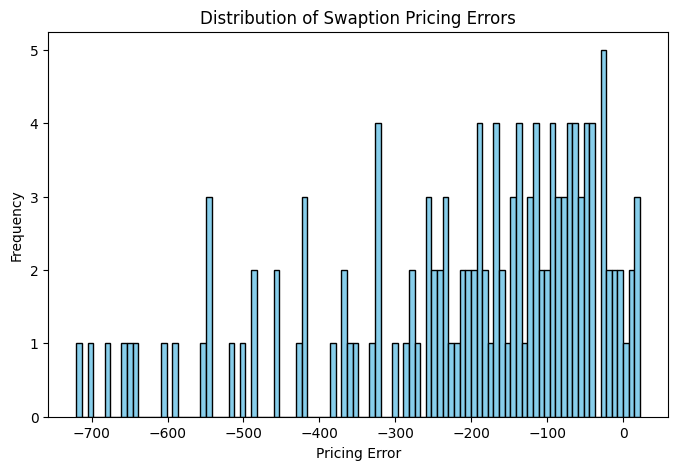

In [10]:
plt.figure(figsize=(8,5))
plt.hist(errors, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Pricing Error")
plt.ylabel("Frequency")
plt.title("Distribution of Swaption Pricing Errors")
plt.show()

Looks like the errors are mostly negative? Curious!! Perhaps it's the result of underestimating the sigma by assuming it's a constant 0.01!

In [9]:
errors

[np.float64(-60.8749982513167),
 np.float64(-29.318199835422035),
 np.float64(-114.48444126405388),
 np.float64(19.49247291906981),
 np.float64(-257.3717195752482),
 np.float64(-87.35171102483713),
 np.float64(-235.5358663978243),
 np.float64(-302.6051403050584),
 np.float64(-502.5863907044113),
 np.float64(-238.0952099225649),
 np.float64(-22.43526393137408),
 np.float64(-2.530455218784269),
 np.float64(-125.21091564104387),
 np.float64(-14.583826531693873),
 np.float64(-25.565910610973077),
 np.float64(-165.19428701871539),
 np.float64(-204.67385379751624),
 np.float64(-321.9595391015914),
 np.float64(-239.0878837963188),
 np.float64(-276.9385017353802),
 np.float64(-273.62115850372913),
 np.float64(-284.57788425466265),
 np.float64(10.193648100423275),
 np.float64(-188.4937430490562),
 np.float64(-233.09691838425186),
 np.float64(-19.12124496471715),
 np.float64(-26.551646082101286),
 np.float64(-720.0833493217117),
 np.float64(-350.97052252683375),
 np.float64(-138.59223862827298),